**Name: Sree Gowri Addepalli**


**Net ID: sga297**

**Date: 2/10/2019**


# Computer Vision CSCI-GA.2272-001 Assignment 1

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/

Please submit your assignment by uploading this iPython notebook to NYU classes.

## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **



In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [33]:
!pip freeze

absl-py==0.8.0
alabaster==0.7.12
albumentations==0.1.12
altair==3.2.0
astor==0.8.0
astropy==3.0.5
atari-py==0.1.15
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.8
autograd==1.3
Babel==2.7.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.0.4
boto==2.49.0
boto3==1.9.236
botocore==1.12.236
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.1
certifi==2019.9.11
cffi==1.12.3
chainer==5.4.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cupy-cuda100==5.4.0
cvxopt==1.2.3
cvxpy==1.0.25
cycler==0.10.0
cymem==2.0.2
Cython==0.29.13
daft==0.0.4
dask==1.1.5
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.0
distributed==1.25.3
Django==2.2.5
dlib==19.16.0
dm-sonnet==1.35
docopt==0.6.2
docutils==0.15.2
dopamine-rl==1.0.5
easydict==1.9
ecos

In [0]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [3]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 18853434.55it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


32768it [00:00, 339395.67it/s]
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 2066154.39it/s]                            
8192it [00:00, 129643.25it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


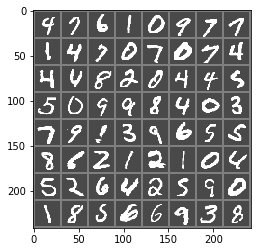

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.


In [0]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [0]:
def train(epoch):
    trainloss = []
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        trainloss.append(loss.item())
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    return trainloss

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss



In [7]:
totaltrainloss = []
totaltestloss = []
for epoch in range(1, epochs + 1):
  totaltrainloss.extend(train(epoch))
  totaltestloss.append(test())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.666768
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.599157
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.448631
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.254775
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.382187
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.351322
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.341265
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.416679
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.455170
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.298631


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3325, Accuracy: 9056/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.331331
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.233105
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.358824
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.200848
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.164617
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.573462
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.392493
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.528184
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.390010
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.549307

Test set: Average loss: 0.3047, Accuracy: 9122/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.471195
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.346728
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.218661
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.267874
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.537847
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.272004
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.298097
Train Epoch: 3 [44800/60000 (75%)]	Loss:

(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: #1 #2)

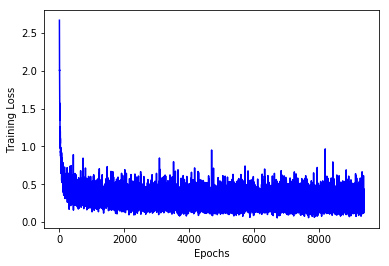

In [8]:
plt.plot(totaltrainloss, 'b')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

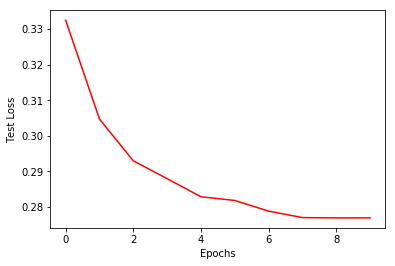

In [9]:
plt.plot(totaltestloss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.show()

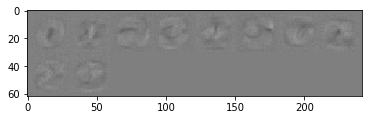

In [10]:
for x in network.modules():
    if isinstance(x, nn.Linear):
      imshow(torchvision.utils.make_grid(x.weight.data.view(10,1,28,28)))

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the train function]. Paste the output into your report and explain what is happening to the model.

In [0]:
trainloader50 = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=0)
testloader50  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
network50 = Net(num_inputs, num_outputs)
optimizer50 = optim.SGD(network50.parameters(), lr=lr)

In [0]:
def trainSamples(epoch):
    train50loss = []
    network50.train()
    for batch_idx, (data, target) in enumerate(trainloader50):
        #print(batch_idx)
        if batch_idx >= 50:
            break;
        data, target = Variable(data), Variable(target)
        optimizer50.zero_grad()
        output = network50(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer50.step()
        train50loss.append(loss.item())
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader50.dataset),
                100. * batch_idx / len(trainloader50), loss.item()))
    return train50loss
        

def testSamples():
    network50.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader50:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network50(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    test_loss /= len(testloader50.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader50.dataset),
        100. * correct / len(testloader50.dataset)))
    return test_loss

In [13]:
trainset50Sampleslosses = []
testset50Sampleslosses = []
for epoch in range(1, epochs + 1):
    trainset50Sampleslosses.extend(trainSamples(epoch))
    testset50Sampleslosses.append(testSamples())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.140966


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.6002, Accuracy: 5112/10000 (51%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.937989

Test set: Average loss: 1.3126, Accuracy: 6006/10000 (60%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.148279

Test set: Average loss: 1.2652, Accuracy: 6167/10000 (61%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.058865

Test set: Average loss: 1.2549, Accuracy: 6204/10000 (62%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.047324

Test set: Average loss: 1.2496, Accuracy: 6225/10000 (62%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.039618

Test set: Average loss: 1.2469, Accuracy: 6219/10000 (62%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.034239

Test set: Average loss: 1.2457, Accuracy: 6230/10000 (62%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.030267

Test set: Average loss: 1.2454, Accuracy: 6246/10000 (62%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.027201

Test set: Average loss: 1.2457, Accuracy: 6253/10000 (62%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.024753

Test set: Average loss: 1.2463, Accuracy: 62

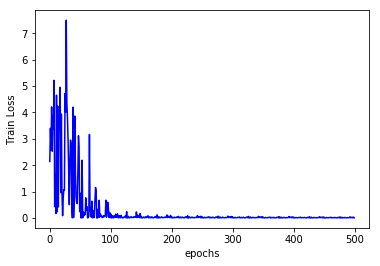

In [14]:
plt.plot(trainset50Sampleslosses, 'b')
plt.xlabel('epochs')
plt.ylabel('Train Loss')
plt.show()

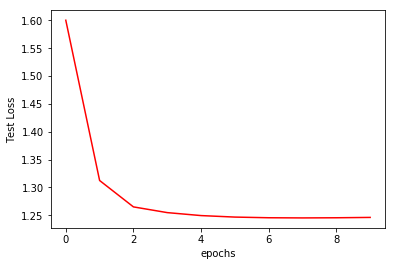

In [15]:
plt.plot(testset50Sampleslosses, 'r')
plt.xlabel('epochs')
plt.ylabel('Test Loss')
plt.show()

In [16]:
for x in network50.modules():
    if isinstance(x, nn.Linear):
      imshow(torchvision.utils.make_grid(x.weight.data.view(10,1,28,28)))

# Results Explanation



1.   The test loss > train loss (from 3rd epoch). 
2.   train loss tends to 0. 
3.   Its Overfitting as test error is high and training error low.
4. The Model doesnt genaralize well from the training data leading to high test loss.





## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation


In [0]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [0]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, hidden, num_outputs):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(hidden, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        intermin = self.linear1(input)
        intermin = self.tanh(intermin)
        output = self.linear2(intermin)
        return output

hidden = 1000
network = Net(num_inputs,hidden, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [19]:
multilayer_trainset_losses = []
multilayer_testset_losses = []
for epoch in range(1, epochs + 1):
    multilayer_trainset_losses.extend(train(epoch))
    multilayer_testset_losses.append(test())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314720
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.771549
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.542519
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.402203
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.398524
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.381759
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.486047
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.308924
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.204860
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.453970


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3254, Accuracy: 9081/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.284284
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.329997
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.260428
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.290420
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.199115
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.284291
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.389818
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.517339
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.173590
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.129288

Test set: Average loss: 0.2826, Accuracy: 9203/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.370992
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.384434
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.151853
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.221837
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.312794
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.313619
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.224285
Train Epoch: 3 [44800/60000 (75%)]	Loss:

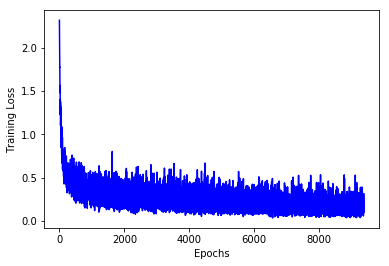

In [20]:
plt.plot(multilayer_trainset_losses, 'b')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

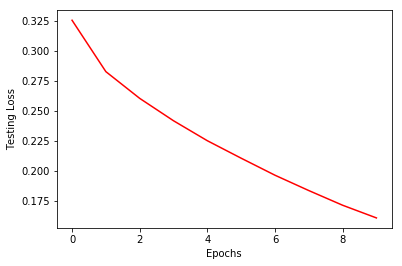

In [21]:
plt.plot(multilayer_testset_losses, 'r')
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')
plt.show()

**Setting the Learning Rate to 10**

In [0]:
optimizer = optim.SGD(network.parameters(), lr=10)

In [23]:
multilayer_trainset_total_losses_changed_lr = []
multilayer_testset_total_losses_changed_lr = []
for epoch in range(1, epochs + 1):
    multilayer_trainset_total_losses_changed_lr.extend(train(epoch))
    multilayer_testset_total_losses_changed_lr.append(test())

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.174441
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1389.486206
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1363.645264
Train Epoch: 1 [19200/60000 (32%)]	Loss: 570.232788
Train Epoch: 1 [25600/60000 (43%)]	Loss: 992.703247
Train Epoch: 1 [32000/60000 (53%)]	Loss: 395.903778
Train Epoch: 1 [38400/60000 (64%)]	Loss: 834.337708
Train Epoch: 1 [44800/60000 (75%)]	Loss: 274.718719
Train Epoch: 1 [51200/60000 (85%)]	Loss: 777.022278
Train Epoch: 1 [57600/60000 (96%)]	Loss: 131.837067


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 277.6235, Accuracy: 6097/10000 (60%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 325.452545
Train Epoch: 2 [6400/60000 (11%)]	Loss: 160.836761
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1152.490112
Train Epoch: 2 [19200/60000 (32%)]	Loss: 413.854675
Train Epoch: 2 [25600/60000 (43%)]	Loss: 234.173248
Train Epoch: 2 [32000/60000 (53%)]	Loss: 181.168549
Train Epoch: 2 [38400/60000 (64%)]	Loss: 455.874939
Train Epoch: 2 [44800/60000 (75%)]	Loss: 686.879028
Train Epoch: 2 [51200/60000 (85%)]	Loss: 160.380371
Train Epoch: 2 [57600/60000 (96%)]	Loss: 602.496582

Test set: Average loss: 495.6805, Accuracy: 4493/10000 (44%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 382.096069
Train Epoch: 3 [6400/60000 (11%)]	Loss: 257.253601
Train Epoch: 3 [12800/60000 (21%)]	Loss: 235.280945
Train Epoch: 3 [19200/60000 (32%)]	Loss: 189.389069
Train Epoch: 3 [25600/60000 (43%)]	Loss: 286.079742
Train Epoch: 3 [32000/60000 (53%)]	Loss: 243.392136
Train Epoch: 3 [38400/60000 (64%)]	Loss: 108.110443
T

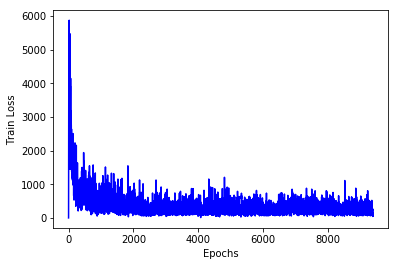

In [24]:
plt.plot(multilayer_trainset_total_losses_changed_lr, 'b')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

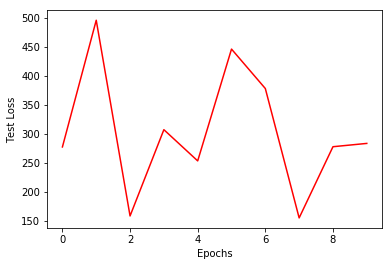

In [25]:
plt.plot(multilayer_testset_total_losses_changed_lr, 'r')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.show()

# Result Explanation

1. We observe small learning rate gets stuck in local minima which might not be global minima.

2. Increasing the learning rate to large learning rate i.e. to 10 may never allow it to reach a minima and can cause the model to converge too quickly to a suboptimal solution.

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [26]:
dataset = "cifar10"

if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

epochs = 20

if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
num_outputs = 10

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 87479797.31it/s]                               


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [0]:
class Net(nn.Module):
    def __init__(self, num_outputs):
        super(Net, self).__init__()
        self.convolutionlayer1 = nn.Conv2d(3, 16, 5)
        self.convolutionlayer2 = nn.Conv2d(16, 128, 5)
        self.linear1 = nn.Linear(128*5*5, 64)
        self.linear2 = nn.Linear(64, num_outputs)

    def forward(self, input):
        input = F.tanh(self.convolutionlayer1(input))
        input = F.max_pool2d(input,2)
        input = F.tanh(self.convolutionlayer2(input))
        input = F.max_pool2d(input, 2)
        input = input.view(-1, self.num_flat_features(input))
        input = F.tanh(self.linear1(input))
        output = self.linear2(input)
        return output
      
    def num_flat_features(self, x):
      size = x.size()[1:]
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


network = Net(num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [0]:
def traindataset(epoch):
    traindataset = []
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        traindataset.append(loss.item())
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return traindataset 
        

def testdataset():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [29]:
totaltrainlosses = []
totaltestlosses = []

for epoch in range(1, epochs + 1):
    totaltrainlosses.extend(traindataset(epoch))
    totaltestlosses.append(testdataset())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304156
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.144524
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.089204
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.015372
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.059205
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.920827
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.800400
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.821243


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.8247, Accuracy: 3711/10000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.654991
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.867526
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.794910
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.740909
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.725383
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.588115
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.751425
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.563151

Test set: Average loss: 1.5967, Accuracy: 4331/10000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.653983
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.447129
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.423729
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.373906
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.587870
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.585231
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.654435
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.482566

Test set: Average loss: 1.4956, Accuracy: 4635/10000 (46%)

Train Epoch: 4 [0/50000 (0%)]

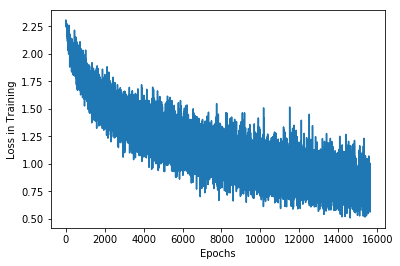

In [30]:
plt.plot(totaltrainlosses)
plt.xlabel('Epochs')
plt.ylabel('Loss in Training')
plt.show()

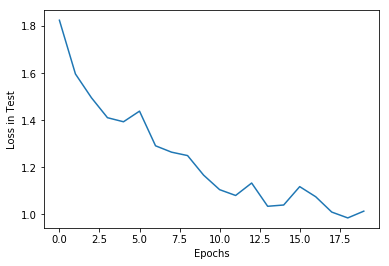

In [31]:
plt.plot(totaltestlosses)
plt.xlabel('Epochs')
plt.ylabel('Loss in Test')
plt.show()

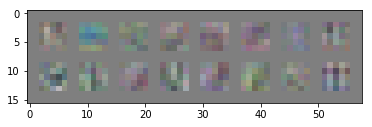

In [32]:
for x in network.modules():
    if isinstance(x, nn.Conv2d):
      imshow(torchvision.utils.make_grid(x.weight.data.cpu()))
      break

**Give a breakdown of the parameters within the above model, and the overall number.**

**1. Convolution Layer:** l feature maps as input, k feature maps as output, filter size is n x m, total number of weights is nmkl, bias term for each feature map, total number of parameters is (nml+1)k.

**2. Fully-connected layers:** For n inputs, m outputs, number of weights is nm, Including bias for output node, there are (n+1)m parameters

**Convolution Layer 1**

weights: 5 * 5 * 3 * 16 = 1200

bias: 16

Total for Convolution Layer 1: 1216

**Convolution Layer 2**

weights: 5 * 5 * 16 * 128 = 51200

bias: 128

Total for Convolution Layer 2: 51328

**Connected Layer 1:**

weights: 128 * 5 * 5 * 64	= 204800

bias: 64	

Total for Connected Layer 1: 204864

**Connected Layer 2:**

weights: 64	* 10 = 640

bias: 10	

Total for Connected Layer 2: 650


**Total: 258058**